# Testing Yan et al. (2010, 2011) on the Radio Galaxy Zoo

Let's run the crowd learning algorithm on the Radio Galaxy Zoo.

In [62]:
from pprint import pprint
import sys

from astropy.coordinates import SkyCoord
import h5py
import numpy
import sklearn.neighbors
import seaborn

sys.path.insert(1, '..')
import crowdastro.active_learning.active_crowd as active_crowd
import crowdastro.active_learning.passive_crowd as passive_crowd
import crowdastro.active_learning.active_crowd_scalar as active_crowd_scalar

CROWDASTRO_H5_PATH = '../data/crowdastro.h5'
TRAINING_H5_PATH = '../data/training.h5'
NORRIS_DAT_PATH = '../data/norris_2006_atlas_classifications_ra_dec_only.dat'

# Load Norris labels.
with h5py.File(TRAINING_H5_PATH, 'r') as training_f:
    ir_positions = training_f['positions'].value
ir_tree = sklearn.neighbors.KDTree(ir_positions)

with open(NORRIS_DAT_PATH, 'r') as norris_dat:
    norris_coords = [r.strip().split('|') for r in norris_dat]

norris_labels = numpy.zeros((len(ir_positions)))
for ra, dec in norris_coords:
    # Find a neighbour.
    skycoord = SkyCoord(ra=ra, dec=dec, unit=('hourangle', 'deg'))
    ra = skycoord.ra.degree
    dec = skycoord.dec.degree
    ((dist,),), ((ir,),) = ir_tree.query([(ra, dec)])
    if dist < 0.1:
        norris_labels[ir] = 1

## How many annotators do we have? How many labels are anonymously contributed?

At the moment, I can only use the algorithm for non-anonymous users. How many are there?

In [2]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    print(sum(1 for i in f_h5['/atlas/cdfs/']['classification_usernames'] if not i)
          / len(f_h5['/atlas/cdfs/']['classification_usernames']))

0.14638396747022944


Only 15% of labels are contributed by anonymous users! That's great for the algorithm. How many users are there?

In [3]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    print(len({i for i in f_h5['/atlas/cdfs/']['classification_usernames'] if i}))

1193


There are 1193 labellers. That's big but hopefully my code can handle it (and if not I'll have to change my methodology a bit).

## Retrieving labels

 Let's pull out some labels. This involves matching each IR object to a label for each annotator. If a IR object never appears in a subject that the annotator has labelled, then it should be masked.

In [4]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    annotators = sorted({i for i in f_h5['/atlas/cdfs/classification_usernames'] if i})
    n_annotators = len(annotators)
    annotator_to_index = {j:i for i, j in enumerate(annotators)}
    
    n_examples = f_h5['/wise/cdfs/numeric'].shape[0]
    
    ir_tree = sklearn.neighbors.KDTree(f_h5['/wise/cdfs/numeric'][:, :2], metric='chebyshev')

In [5]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    labels = numpy.ma.MaskedArray(numpy.zeros((n_annotators, n_examples)),
                                  mask=numpy.ones((n_annotators, n_examples)))
    
    for (atlas_idx, ra, dec), c_user in zip(
            f_h5['/atlas/cdfs/classification_positions'],
            f_h5['/atlas/cdfs/classification_usernames'],
    ):
        if not c_user:
            continue

        t = annotator_to_index[c_user]
        
        atlas_ra, atlas_dec = f_h5['/atlas/cdfs/numeric'][atlas_idx, :2]
        
        # t has seen this ATLAS subject, so unmask everything within 1' Chebyshev distance (the radius of an RGZ subject).
        nearby = ir_tree.query_radius([[atlas_ra, atlas_dec]], 1 / 60)[0]
        labels.mask[t, nearby] = 0

        # Label the point nearest the classification as 1.
        # (The others are 0 by default.)
        if numpy.isnan(ra) or numpy.isnan(dec):
            continue

        point = ir_tree.query([[ra, dec]], return_distance=False)[0]
        labels[t, point] = 1

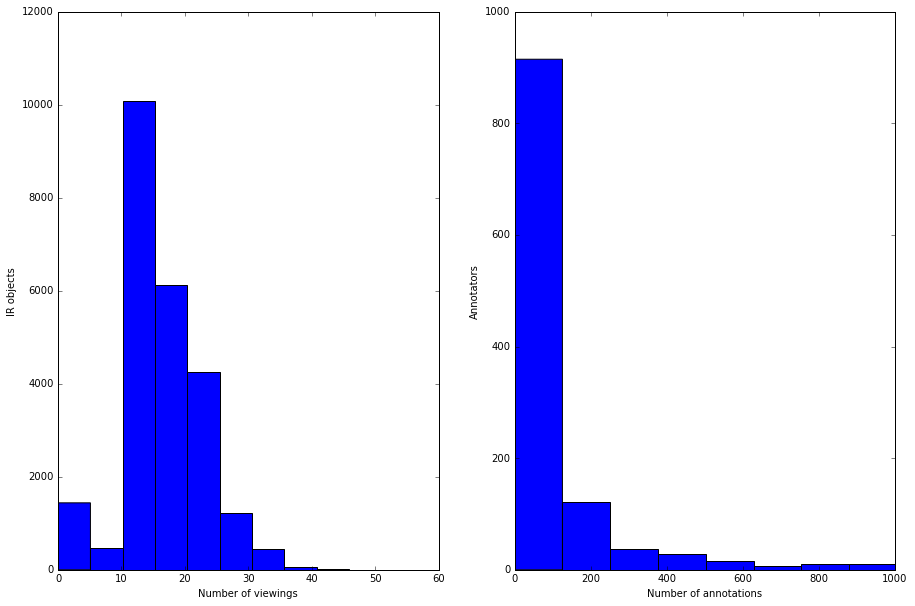

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.hist((~labels.mask).sum(axis=0))
plt.xlabel('Number of viewings')
plt.ylabel('IR objects')
plt.subplot(1, 2, 2)
plt.hist((~labels.mask).sum(axis=1), bins=numpy.linspace(0, 25000, 200))
plt.xlim((0, 1000))
plt.xlabel('Number of annotations')
plt.ylabel('Annotators')

## How good are the annotators? [#127](https://github.com/chengsoonong/crowdastro/issues/127)

What is the distribution of balanced accuracies for each annotator? Can we estimate $p(y_i^{(t)} | x_i, z_i)$?

In [7]:
import sklearn.metrics

accuracies = []
annotator_to_accuracy = {}
for t in range(n_annotators):
    mask = labels[t].mask
    cm = sklearn.metrics.confusion_matrix(norris_labels[~mask], labels[t, ~mask]).astype(float)
    if cm.shape == (1, 1):
        continue

    tp = cm[1, 1]
    n, p = cm.sum(axis=1)
    tn = cm[0, 0]
    if not (n and p):
        continue

    ba = (tp / p + tn / n) / 2
    accuracies.append(ba)
    annotator_to_accuracy[t] = ba

print('{:.02%} of labellers have a balanced accuracy.'.format(len(accuracies) / n_annotators))

74.27% of labellers have a balanced accuracy.


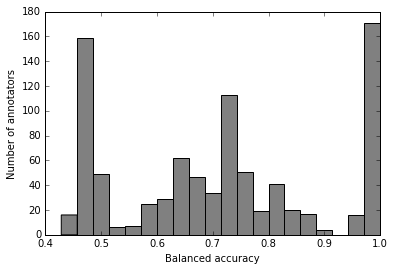

Average: (71.03 +- 18.29)%


In [8]:
plt.hist(accuracies, color='grey', bins=20)
plt.xlabel('Balanced accuracy')
plt.ylabel('Number of annotators')
plt.show()

print('Average: ({:.02f} +- {:.02f})%'.format(numpy.mean(accuracies) * 100, numpy.std(accuracies) * 100))

## How many annotators are experts?

In [9]:
experts = ("42jkb", "ivywong", "stasmanian", "klmasters", "Kevin",
           "akapinska", "enno.middelberg", "xDocR", "DocR", "vrooje", "KWillett")
print([expert for expert in experts if expert.encode('ascii') in annotators])

['KWillett']


## How many positive examples have the top 10 annotators labelled?

In [10]:
counts = [(numpy.ma.sum(labels[t] == 1), t) for t in range(n_annotators)]
counts.sort()
pprint([(annotator_to_accuracy[t], t, count) for count, t in counts[-10:]])

top_10 = sorted([t for _, t in counts[-10:]])

[(0.75797582455910884, 1169, 519),
 (0.75699271733750673, 135, 683),
 (0.75924796624019708, 64, 962),
 (0.69394703116773282, 314, 1500),
 (0.7682293723857847, 662, 1893),
 (0.77407966065131606, 1062, 1916),
 (0.80921568705428282, 604, 1967),
 (0.81688934170995275, 1051, 1970),
 (0.82859181461409082, 978, 2006),
 (0.83511567214955051, 490, 2233)]


In [11]:
for annotator, count in [(annotators[t], count) for count, t in reversed(counts)]:
    print(annotator.decode('utf-8'), '\t', count)

antikodon 	 2233
planetari7 	 2006
sisifolibre 	 1970
csunjoto 	 1967
snowysky 	 1916
equidad1 	 1893
PattyD 	 1500
ChaMei 	 962
Explorer15 	 683
willy71 	 519
cripple85 	 506
JeanTate 	 430
Mitch56 	 427
Mimocarino 	 398
HelmutU 	 358
Dolorous Edd 	 337
ControlledChaos 	 268
arianna99 	 260
shocko61 	 219
Shade017@umn.edu 	 205
rm3082 	 196
tbrockhaus 	 179
ChrisMolloy 	 172
graham d 	 171
pamelaann 	 165
G.Costalunga 	 137
brandon.mariano 	 126
Weissoniq 	 124
1001G 	 118
flecmm03 	 116
parkerm126 	 115
ruprechtludwig 	 113
ashleysuzanne 	 105
kobo123 	 102
Gary Michael 	 100
tom324232 	 99
Prothon 	 95
romulous_ErrorDupUsername 	 93
bobk47 	 92
alinejojo 	 91
mixu74 	 90
Rock Beauty 	 86
Jimg3d 	 84
Swann2501 	 83
fiskmannen 	 76
gavinrider 	 70
WizardHowl 	 67
WEBs in space 	 65
armybro1 	 64
Engel1587 	 62
dhiana 	 60
chiliking 	 60
area53 	 59
legacyhardware 	 58
gwallingford 	 58
Missybee35 	 58
olbo 	 57
ehinterm 	 57
radek45 	 56
spaceygeek 	 55
Codo 	 54
Vic7or 	 52
cjunco 	 

## Running the algorithm on the top 10 annotators

Let's throw in just the top 10 annotators [#126](https://github.com/chengsoonong/crowdastro/issues/126) and see how it goes. First, I'll downsample the negative examples. I'll count a "negative" example as anything that doesn't have any positive classifications.

In [54]:
top_labels = labels[top_10]

non_negative_bool = numpy.any(top_labels, axis=0)
non_negatives = numpy.arange(top_labels.shape[1])[non_negative_bool]
negatives = numpy.arange(top_labels.shape[1])[~non_negative_bool]

numpy.random.shuffle(negatives)
negatives = negatives[:non_negatives.shape[0]]

In [55]:
assert negatives.shape == non_negatives.shape

downsampled = numpy.hstack([non_negatives, negatives])
downsampled.sort()

In [56]:
downsampled_train, downsampled_test = sklearn.cross_validation.train_test_split(downsampled)
downsampled_train.sort()
downsampled_test.sort()

Now I can run the algorithm.

In [41]:
print(downsampled_train.shape, downsampled_test.shape)

with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features'][downsampled_train, :]
    res = passive_crowd.train(x, top_labels.astype(bool)[:, downsampled_train], lr_init=True)

(5229,) (1743,)


K:\Languages\Python35_64\lib\site-packages\numpy\ma\core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [43]:
import sklearn.metrics

with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    pred = passive_crowd.predict(res[0], res[1], x[downsampled_test, :])
    cm = sklearn.metrics.confusion_matrix(norris_labels[downsampled_test], pred)
    
    tp = cm[1, 1]
    n, p = cm.sum(axis=1)
    tn = cm[0, 0]

    ba = (tp / p + tn / n) / 2
    print(ba)
    print(cm)

0.64359709937
[[1494  108]
 [  91   50]]


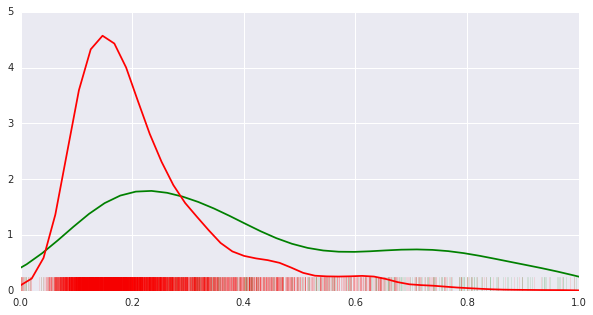

In [45]:
import seaborn, matplotlib.pyplot as plt
%matplotlib inline

with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    pred = passive_crowd.logistic_regression(res[0], res[1], x[downsampled_train, :])
    pos_pred = pred[norris_labels[downsampled_train] == 1]
    neg_pred = pred[norris_labels[downsampled_train] == 0]
    assert pos_pred.shape[0] + neg_pred.shape[0] == pred.shape[0]
    plt.figure(figsize=(10, 5))
    seaborn.distplot(pos_pred, rug=True, hist=False, color='green', rug_kws={'alpha': 0.1})
    seaborn.distplot(neg_pred, rug=True, hist=False, color='red', rug_kws={'alpha': 0.1})
    plt.xlim((0, 1))
    plt.show()

## Running the algorithm on simulated labellers, no noise

I'll use the Norris labels to generate true labels for a partially observed crowd labelling scenario. 

In [100]:
simulated_norris_labels = numpy.ma.MaskedArray(numpy.tile(norris_labels, (5, 1)),
                                               mask=numpy.random.binomial(1, 0.5, size=(5, 24140)))

In [101]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features'][downsampled_train, :]
    res = passive_crowd.train(x, simulated_norris_labels.astype(bool)[:, downsampled_train], lr_init=True)

K:\Languages\Python35_64\lib\site-packages\numpy\ma\core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [102]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    pred = passive_crowd.predict(res[0], res[1], x[downsampled_test, :])
    cm = sklearn.metrics.confusion_matrix(norris_labels[downsampled_test], pred)
    
    tp = cm[1, 1]
    n, p = cm.sum(axis=1)
    tn = cm[0, 0]

    ba = (tp / p + tn / n) / 2
    print(ba)
    print(cm)

0.593872021675
[[1596    6]
 [ 114   27]]


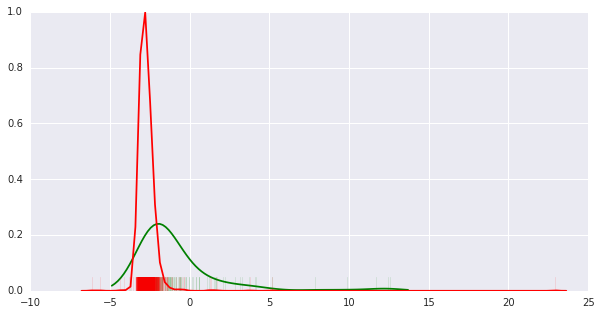

In [105]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    score = res[0].dot(x[downsampled_test, :].T) + res[1]
    pos_score = score[norris_labels[downsampled_test] == 1]
    neg_score = score[norris_labels[downsampled_test] == 0]
    assert pos_score.shape[0] + neg_score.shape[0] == score.shape[0]
    plt.figure(figsize=(10, 5))
    seaborn.distplot(pos_score, rug=True, hist=False, color='green', rug_kws={'alpha': 0.1})
    seaborn.distplot(neg_score, rug=True, hist=False, color='red', rug_kws={'alpha': 0.1})
    plt.show()

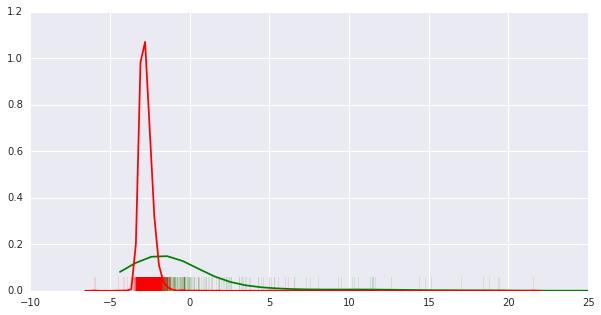

In [107]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    score = res[0].dot(x[downsampled_train, :].T) + res[1]
    pos_score = score[norris_labels[downsampled_train] == 1]
    neg_score = score[norris_labels[downsampled_train] == 0]
    assert pos_score.shape[0] + neg_score.shape[0] == score.shape[0]
    plt.figure(figsize=(10, 5))
    seaborn.distplot(pos_score, rug=True, hist=False, color='green', rug_kws={'alpha': 0.1})
    seaborn.distplot(neg_score, rug=True, hist=False, color='red', rug_kws={'alpha': 0.1})
    plt.xlim((-10, 25))
    plt.show()

## Norris Baseline

Just a quick comparison with the Norris labels, fully observed and one annotator.

In [109]:
import sklearn.linear_model

lr = sklearn.linear_model.LogisticRegression(C=100)
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    lr.fit(x[downsampled_train, :], norris_labels[downsampled_train])

In [112]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    pred = lr.predict(x[downsampled_test, :])
    cm = sklearn.metrics.confusion_matrix(norris_labels[downsampled_test], pred)
    
    tp = cm[1, 1]
    n, p = cm.sum(axis=1)
    tn = cm[0, 0]

    ba = (tp / p + tn / n) / 2
    print(ba)
    print(cm)

0.715488617951
[[1588   14]
 [  79   62]]


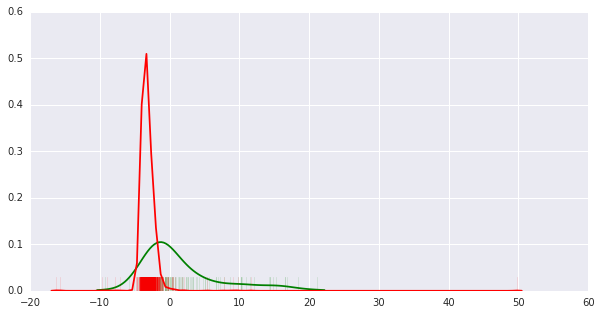

In [110]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    score = lr.decision_function(x[downsampled_test, :])
    pos_score = score[norris_labels[downsampled_test] == 1]
    neg_score = score[norris_labels[downsampled_test] == 0]
    assert pos_score.shape[0] + neg_score.shape[0] == score.shape[0]
    plt.figure(figsize=(10, 5))
    seaborn.distplot(pos_score, rug=True, hist=False, color='green', rug_kws={'alpha': 0.1})
    seaborn.distplot(neg_score, rug=True, hist=False, color='red', rug_kws={'alpha': 0.1})
    plt.show()

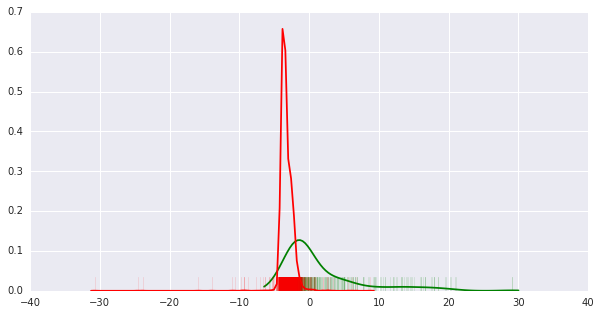

In [111]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    score = lr.decision_function(x[downsampled_train, :])
    pos_score = score[norris_labels[downsampled_train] == 1]
    neg_score = score[norris_labels[downsampled_train] == 0]
    assert pos_score.shape[0] + neg_score.shape[0] == score.shape[0]
    plt.figure(figsize=(10, 5))
    seaborn.distplot(pos_score, rug=True, hist=False, color='green', rug_kws={'alpha': 0.1})
    seaborn.distplot(neg_score, rug=True, hist=False, color='red', rug_kws={'alpha': 0.1})
    plt.show()

## Top 10 annotators with scalar $\eta_t$

In [88]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features'][downsampled_train, :]
    res = active_crowd_scalar.train(x, top_labels.astype(bool)[:, downsampled_train], lr_init=True)

K:\Languages\Python35_64\lib\site-packages\numpy\ma\core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [89]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    pred = passive_crowd.predict(res[0], res[1], x[downsampled_test, :])
    cm = sklearn.metrics.confusion_matrix(norris_labels[downsampled_test], pred)
    
    tp = cm[1, 1]
    n, p = cm.sum(axis=1)
    tn = cm[0, 0]

    ba = (tp / p + tn / n) / 2
    print(ba)
    print(cm)

0.718941748346
[[1440  162]
 [  65   76]]


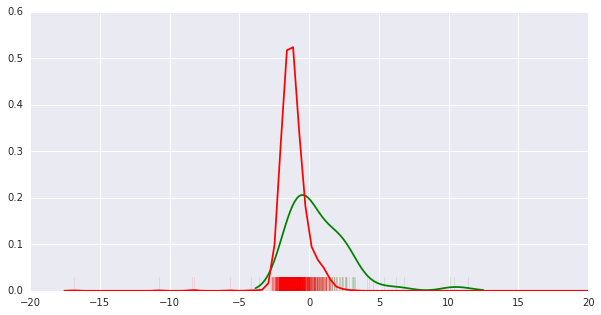

In [98]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    score = res[0].dot(x[downsampled_test, :].T) + res[1]
    pos_score = score[norris_labels[downsampled_test] == 1]
    neg_score = score[norris_labels[downsampled_test] == 0]
    assert pos_score.shape[0] + neg_score.shape[0] == score.shape[0]
    plt.figure(figsize=(10, 5))
    seaborn.distplot(pos_score, rug=True, hist=False, color='green', rug_kws={'alpha': 0.1})
    seaborn.distplot(neg_score, rug=True, hist=False, color='red', rug_kws={'alpha': 0.1})
    plt.xlim((-20, 20))
    plt.show()

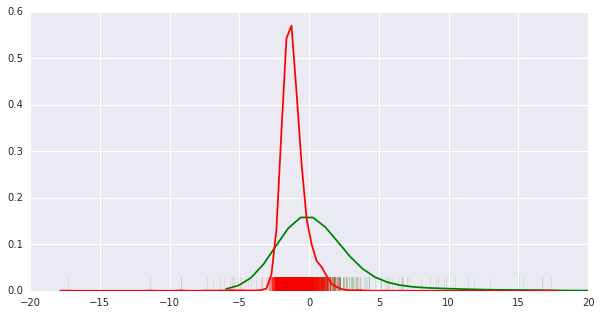

In [97]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    score = res[0].dot(x[downsampled_train, :].T) + res[1]
    pos_score = score[norris_labels[downsampled_train] == 1]
    neg_score = score[norris_labels[downsampled_train] == 0]
    assert pos_score.shape[0] + neg_score.shape[0] == score.shape[0]
    plt.figure(figsize=(10, 5))
    seaborn.distplot(pos_score, rug=True, hist=False, color='green', rug_kws={'alpha': 0.1})
    seaborn.distplot(neg_score, rug=True, hist=False, color='red', rug_kws={'alpha': 0.1})
    plt.xlim((-20, 20))
    plt.show()

In [92]:
res[2]

array([ 0.13664592,  0.37203094,  0.2565089 ,  0.74780762,  0.02890832,
        0.81651655,  0.12864316,  0.02816478,  0.16995135,  0.3093587 ])

## Clustering annotators

First, let's make a covariance matrix.

In [17]:
cov = numpy.ma.cov(labels)
print(cov, cov.shape)

[[0.06666666666666668 0.06666666666666667 -- ..., -- -- --]
 [0.06666666666666667 0.05500511951244607 0.03833333333333335 ..., --
  -9.912705577010326e-19 --]
 [-- 0.03833333333333335 0.07666666666666666 ..., -- -- --]
 ..., 
 [-- -- -- ..., 0.06495589414595031 -- --]
 [-- -9.912705577010326e-19 -- ..., -- 0.125 --]
 [-- -- -- ..., -- -- 0.06666666666666668]] (1193, 1193)


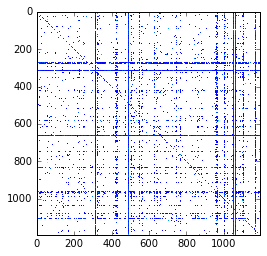

In [18]:
plt.imshow(cov, interpolation='None')

As expected, lots of unknowns. We'll press on nevertheless!

In [34]:
import sklearn.cluster, collections

In [29]:
kmc = sklearn.cluster.KMeans(5)
kmc.fit(cov)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [33]:
clusters = kmc.predict(cov)

Now, we'll do a majority vote over these clusters.

In [37]:
cluster_labels = numpy.ma.MaskedArray(numpy.zeros((5, labels.shape[1])), mask=numpy.zeros((5, labels.shape[1])))
for c in range(5):
    for i in range(labels.shape[1]):
        this_cluster_labels = labels[clusters == c, i]
        # Compute the majority vote.
        counter = collections.Counter(this_cluster_labels[~this_cluster_labels.mask])
        if counter:
            cluster_labels[c, i] = max(counter, key=counter.get)
        else:
            cluster_labels.mask[c, i] = True

Now let's try a basic logistic regression on each of them.

In [59]:
def balanced_accuracy(y_true, y_pred):
    try:
        cm = sklearn.metrics.confusion_matrix(y_true[~y_pred.mask], y_pred[~y_pred.mask])
    except AttributeError:
        cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    tp = cm[1, 1]
    n, p = cm.sum(axis=1)
    tn = cm[0, 0]

    ba = (tp / p + tn / n) / 2
    return ba

In [52]:
i_tr, i_te = sklearn.cross_validation.train_test_split(numpy.arange(labels.shape[1]))

with h5py.File(TRAINING_H5_PATH) as f_h5:
    features = f_h5['features'].value
    for c in range(5):
        labels_ = cluster_labels[c]
        lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
        lr.fit(features[i_tr], labels_[i_tr])
        print(balanced_accuracy(norris_labels[i_te], lr.predict(features[i_te])))

0.727235774647
0.715165678675
0.754294782614
0.723188656146
0.5


Next, we'll put it into the scalar $\eta_t$ implementation.

In [57]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features'][downsampled_train, :]
    res = active_crowd_scalar.train(x, cluster_labels.astype(bool)[:, downsampled_train], lr_init=True)

K:\Languages\Python35_64\lib\site-packages\numpy\ma\core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
K:\Languages\Python35_64\lib\site-packages\numpy\ma\core.py:827: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


In [60]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    pred = passive_crowd.predict(res[0], res[1], x[downsampled_test, :])
    cm = sklearn.metrics.confusion_matrix(norris_labels[downsampled_test], pred)
    ba = balanced_accuracy(norris_labels[downsampled_test], pred)
    print(cm)
    print(ba)

[[1568   21]
 [ 121   33]]
0.600534927627


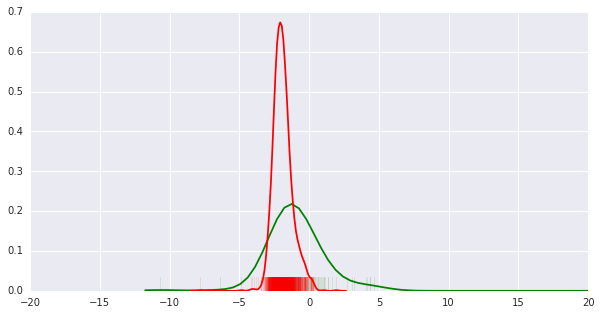

In [63]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    score = res[0].dot(x[downsampled_test, :].T) + res[1]
    pos_score = score[norris_labels[downsampled_test] == 1]
    neg_score = score[norris_labels[downsampled_test] == 0]
    assert pos_score.shape[0] + neg_score.shape[0] == score.shape[0]
    plt.figure(figsize=(10, 5))
    seaborn.distplot(pos_score, rug=True, hist=False, color='green', rug_kws={'alpha': 0.1})
    seaborn.distplot(neg_score, rug=True, hist=False, color='red', rug_kws={'alpha': 0.1})
    plt.xlim((-20, 20))
    plt.show()

Now let's try the full algorithm.

In [67]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features'][downsampled_train, :]
    res = active_crowd.train(x, cluster_labels.astype(bool)[:, downsampled_train], lr_init=True)

K:\Languages\Python35_64\lib\site-packages\numpy\ma\core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [68]:
with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    pred = passive_crowd.predict(res[0], res[1], x[downsampled_test, :])
    cm = sklearn.metrics.confusion_matrix(norris_labels[downsampled_test], pred)
    ba = balanced_accuracy(norris_labels[downsampled_test], pred)
    print(cm)
    print(ba)

[[   0 1589]
 [   1  153]]
0.496753246753


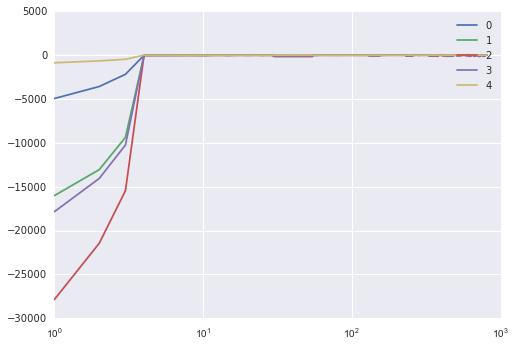

In [78]:
plt.plot(res[2].T)
plt.xscale('log')
plt.legend(range(5))

In [79]:
print(res[3])

[ -206.06684877  -995.36668545 -1651.16336611 -1076.5866288    -48.6273634 ]
